In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from model import NeuralNet
from nltkUtils import bag_of_words, tokenize, stem

In [2]:
with open('data/intents.json', 'r', encoding='utf-8') as f:
    intents = json.load(f)
all_words = []
tags = []
xy = []

In [3]:
for intent in intents['intents']:
    tag = intent['tag']
    tags.append(tag)
    for pattern in intent['patterns']:
        w = tokenize(pattern)
        all_words.extend(w)
        xy.append((w, tag))

In [4]:
ignore_words = ['?', '.', '!']
all_words = [stem(w) for w in all_words if w not in ignore_words]
all_words = sorted(set(all_words))
tags = sorted(set(tags))

In [5]:
X_train = []
y_train = []
for (pattern_sentence, tag) in xy:
    bag = bag_of_words(pattern_sentence, all_words)
    X_train.append(bag)
    label = tags.index(tag)
    y_train.append(label)


In [6]:
X_train = np.array(X_train)
y_train = np.array(y_train)
num_epochs = 1000
batch_size = 8
learning_rate = 0.001
input_size = len(X_train[0])
hidden_size = 8
output_size = len(tags)
print(input_size, output_size)

114 14


In [7]:
class ChatDataset(Dataset):
    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.n_samples

In [8]:
num_epochs = 1000
batch_size = 8
learning_rate = 0.001
input_size = len(X_train[0])
hidden_size = 8
output_size = len(tags)

In [9]:
dataset = ChatDataset()
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
model = NeuralNet(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [11]:
loss_values = []
for epoch in range(num_epochs):
    for (words, labels) in train_loader:
        words = words.to(device)
        labels = labels.to(dtype=torch.long).to(device)
        outputs = model(words)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_values.append(loss.item())
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print(f'Final loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.2799
Epoch [200/1000], Loss: 0.0121
Epoch [300/1000], Loss: 0.1097
Epoch [400/1000], Loss: 0.0019
Epoch [500/1000], Loss: 0.0015
Epoch [600/1000], Loss: 0.0007
Epoch [700/1000], Loss: 0.0001
Epoch [800/1000], Loss: 0.0001
Epoch [900/1000], Loss: 0.0002
Epoch [1000/1000], Loss: 0.0001
Final loss: 0.0001


In [12]:
data = {
    "model_state": model.state_dict(),
    "input_size": input_size,
    "hidden_size": hidden_size,
    "output_size": output_size,
    "all_words": all_words,
    "tags": tags
}

FILE = "data.pth"
torch.save(data, FILE)
print(f'Training complete. File saved to {FILE}')

Training complete. File saved to data.pth


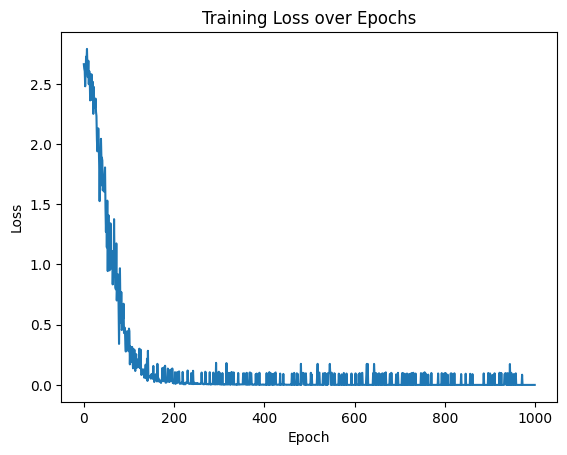

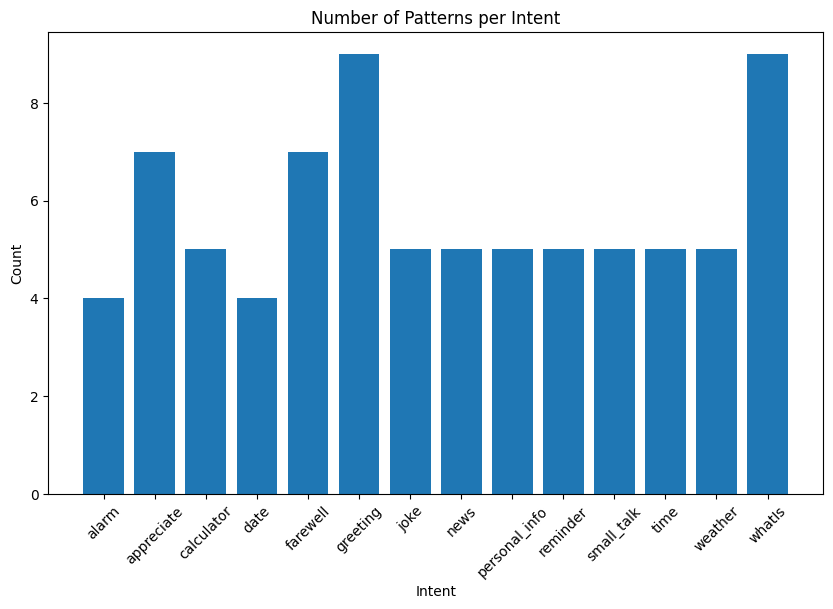

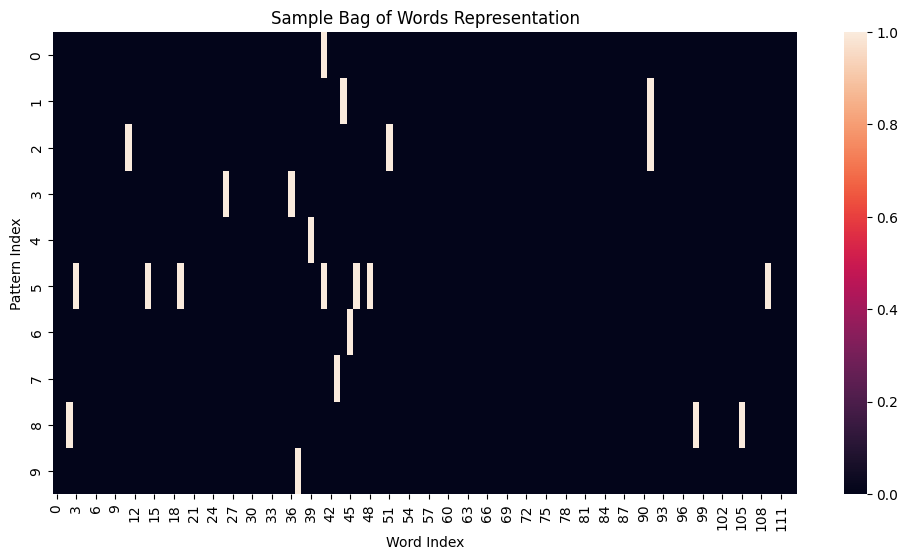

In [13]:
plt.plot(range(num_epochs), loss_values)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

intent_counts = {tag: 0 for tag in tags}
for _, tag in xy:
    intent_counts[tag] += 1

plt.figure(figsize=(10, 6))
plt.bar(intent_counts.keys(), intent_counts.values())
plt.title('Number of Patterns per Intent')
plt.xlabel('Intent')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(X_train[:10], annot=False, cbar=True)
plt.title("Sample Bag of Words Representation")
plt.xlabel("Word Index")
plt.ylabel("Pattern Index")
plt.show()
